In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import keras.callbacks as callbacks
from keras.layers.wrappers import TimeDistributed
from keras.utils import multi_gpu_model

Using TensorFlow backend.


input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [2]:
def sliced(x):
    return x[:,0,:,:]

nInput = 5

input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(nInput, 400,400,1), name='input2')

time1 = ConvLSTM2D(32, kernel_size=(9,9), padding='same', activation='relu', return_sequences=True)(input2)
time1 = ConvLSTM2D(16, kernel_size=(1,1), padding='same', activation='relu', return_sequences=True)(time1)
time1 = ConvLSTM2D(1, kernel_size=(3,3), padding='same', activation='relu')(time1)
time = Dropout(0.3)(time1)
# time = Lambda(sliced)(time1)

conv_1 = Conv2D(30, (3, 3), padding='same')(input1)
conv_2 = Conv2D(30, (3, 3), padding='same')(time)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

concat_1_2 = Dropout(0.3)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(3, 5),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

feature_3_5_7 = Dropout(0.3)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=30, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv2, conv_2])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv5, conv3])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6)


model = Model([input1, input2], conv7)

# model = multi_gpu_model(model, gpus=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Read dataset

In [3]:
import h5py

f = h5py.File('dataset5_255.hdf5', 'r')

in1 = f['in1'][:]
in2 = f['in2'][:]
in3 = f['in3'][:]
in4 = f['in4'][:]
in5 = f['in5'][:]
masked = f['masked'][:]
out = f['out'][:]
f.close()

### Config Model

In [4]:
def PSNRLoss(y_true, y_pred):
    return 10. * K.log(255.0 * 255.0 / K.mean(K.square(y_pred - y_true))) / K.log(10.)

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.3
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [5]:
nTrain = int(0.9 * len(in1))
nTest = len(in1) - nTrain

trainX_2 = np.zeros((nTrain, 5, 400, 400, 1), dtype='float32')
testX_2 = np.zeros((nTest, 5, 400, 400, 1), dtype='float32')

trainX_1 = masked[:nTrain,:,:,:]
trainX_2[:,0,:,:,0] = in1[:nTrain,:,:,0]
trainX_2[:,1,:,:,0] = in2[:nTrain,:,:,0]
trainX_2[:,2,:,:,0] = in3[:nTrain,:,:,0]
trainX_2[:,3,:,:,0] = in4[:nTrain,:,:,0]
trainX_2[:,4,:,:,0] = in5[:nTrain,:,:,0]
trainY = out[:nTrain,:,:,:]

testX_1 = masked[nTrain:,:,:,:]
testX_2[:,0,:,:,0] = in1[nTrain:,:,:,0]
testX_2[:,1,:,:,0] = in2[nTrain:,:,:,0]
testX_2[:,2,:,:,0] = in3[nTrain:,:,:,0]
testX_2[:,3,:,:,0] = in4[nTrain:,:,:,0]
testX_2[:,4,:,:,0] = in5[nTrain:,:,:,0]
testY = out[nTrain:,:,:,:]

In [6]:
adam = Adam(lr=0.0001)

model.compile(optimizer=adam, loss='mse', metrics=[PSNRLoss])

lrate = LearningRateScheduler(step_decay)
callback_list = [callbacks.ModelCheckpoint('conv2dlstm_1708_255_checkpoint.h5', monitor='val_PSNRLoss', save_best_only=True,
                                           mode='max', save_weights_only=True, verbose=1)]

batch_size = 3
nb_epoch = 150

history = model.fit([trainX_1, trainX_2], trainY, batch_size=batch_size, epochs=nb_epoch, callbacks=callback_list,
                    verbose=1, validation_data=([testX_1, testX_2], testY))  

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 1004 samples, validate on 112 samples
Epoch 1/150
1004/1004 [==============================] - 371s 370ms/step - loss: 257.8692 - PSNRLoss: 26.4526 - val_loss: 49.0679 - val_PSNRLoss: 31.5586
Epoch 2/150
1004/1004 [==============================] - 362s 361ms/step - loss: 78.9904 - PSNRLoss: 29.8009 - val_loss: 42.7202 - val_PSNRLoss: 32.1712
Epoch 3/150
1004/1004 [==============================] - 362s 361ms/step - loss: 69.0843 - PSNRLoss: 30.3662 - val_loss: 54.7431 - val_PSNRLoss: 30.9793
Epoch 4/150
1004/1004 [==============================] - 362s 361ms/step - loss: 63.9207 - PSNRLoss: 30.7848 - val_loss: 80.8258 - val_PSNRLoss: 29.2042
Epoch 5/150
1004/1004 [==============================] - 362s 361ms/step - loss: 59.5507 - PSNRLoss: 31.0723 - val_loss: 90.2780 - val_PSNRLoss: 28.7784
Epoch 6/150
1004/1004 [==============================] - 362s 361ms/step - loss: 57.1456 - PSNRLoss: 31.3551 - val

Epoch 57/150
1004/1004 [==============================] - 361s 360ms/step - loss: 36.8234 - PSNRLoss: 33.4586 - val_loss: 181.4743 - val_PSNRLoss: 25.6898
Epoch 58/150
1004/1004 [==============================] - 361s 360ms/step - loss: 36.8030 - PSNRLoss: 33.3965 - val_loss: 220.1044 - val_PSNRLoss: 24.8481
Epoch 59/150
1004/1004 [==============================] - 361s 360ms/step - loss: 36.7585 - PSNRLoss: 33.4577 - val_loss: 217.6694 - val_PSNRLoss: 24.8910
Epoch 60/150
1004/1004 [==============================] - 361s 360ms/step - loss: 36.8480 - PSNRLoss: 33.5313 - val_loss: 230.3076 - val_PSNRLoss: 24.6421
Epoch 61/150
1004/1004 [==============================] - 362s 360ms/step - loss: 36.7502 - PSNRLoss: 33.4422 - val_loss: 230.1732 - val_PSNRLoss: 24.6446
Epoch 62/150
1004/1004 [==============================] - 361s 360ms/step - loss: 36.9334 - PSNRLoss: 33.4511 - val_loss: 225.2997 - val_PSNRLoss: 24.7420
Epoch 63/150
1004/1004 [==============================] - 361s 360ms/s

Epoch 86/150
1004/1004 [==============================] - 362s 361ms/step - loss: 35.3672 - PSNRLoss: 33.6270 - val_loss: 236.4012 - val_PSNRLoss: 24.5193
Epoch 87/150
1004/1004 [==============================] - 362s 361ms/step - loss: 35.2609 - PSNRLoss: 33.7241 - val_loss: 233.5165 - val_PSNRLoss: 24.5865
Epoch 88/150
1004/1004 [==============================] - 362s 361ms/step - loss: 35.2644 - PSNRLoss: 33.7294 - val_loss: 220.9478 - val_PSNRLoss: 24.8131
Epoch 89/150
1004/1004 [==============================] - 362s 361ms/step - loss: 35.1217 - PSNRLoss: 33.6985 - val_loss: 216.9171 - val_PSNRLoss: 24.8949
Epoch 90/150
1004/1004 [==============================] - 363s 361ms/step - loss: 35.0929 - PSNRLoss: 33.6746 - val_loss: 218.8695 - val_PSNRLoss: 24.8675
Epoch 91/150
1004/1004 [==============================] - 363s 361ms/step - loss: 34.9038 - PSNRLoss: 33.7793 - val_loss: 226.5044 - val_PSNRLoss: 24.7045
Epoch 92/150
1004/1004 [==============================] - 362s 361ms/s

Epoch 115/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.2586 - PSNRLoss: 33.7861 - val_loss: 212.7414 - val_PSNRLoss: 24.9917
Epoch 116/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.2229 - PSNRLoss: 33.8715 - val_loss: 214.9303 - val_PSNRLoss: 24.9434
Epoch 117/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.0997 - PSNRLoss: 33.9063 - val_loss: 229.5112 - val_PSNRLoss: 24.6579
Epoch 118/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.5011 - PSNRLoss: 33.7314 - val_loss: 222.7655 - val_PSNRLoss: 24.7823
Epoch 119/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.1451 - PSNRLoss: 33.8836 - val_loss: 211.8861 - val_PSNRLoss: 25.0033
Epoch 120/150
1004/1004 [==============================] - 362s 361ms/step - loss: 34.3090 - PSNRLoss: 33.8874 - val_loss: 222.7926 - val_PSNRLoss: 24.7850
Epoch 121/150
1004/1004 [==============================] - 362s 

Epoch 144/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.8278 - PSNRLoss: 33.7929 - val_loss: 215.5148 - val_PSNRLoss: 24.9350
Epoch 145/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.6718 - PSNRLoss: 34.0442 - val_loss: 211.6623 - val_PSNRLoss: 25.0064
Epoch 146/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.5964 - PSNRLoss: 33.9174 - val_loss: 221.9123 - val_PSNRLoss: 24.8017
Epoch 147/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.5367 - PSNRLoss: 33.9953 - val_loss: 217.8411 - val_PSNRLoss: 24.8927
Epoch 148/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.6531 - PSNRLoss: 34.0006 - val_loss: 225.0588 - val_PSNRLoss: 24.7486
Epoch 149/150
1004/1004 [==============================] - 362s 361ms/step - loss: 33.3926 - PSNRLoss: 33.9072 - val_loss: 220.6173 - val_PSNRLoss: 24.8324
Epoch 150/150
1004/1004 [==============================] - 362s 

In [7]:
y_pred = model.predict([testX_1[10:11], testX_2[10:11]])

Original Input

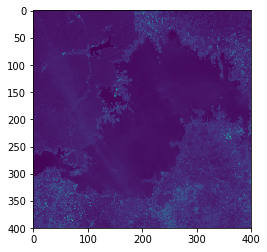

In [8]:
plt.imshow(testY[0,:,:,0])

Predicted

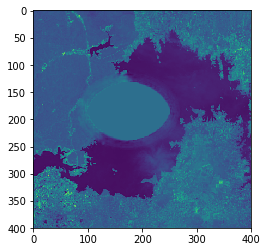

In [9]:
plt.imshow(y_pred[0,:,:,0])

In [10]:
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'val_PSNRLoss', 'PSNRLoss'])


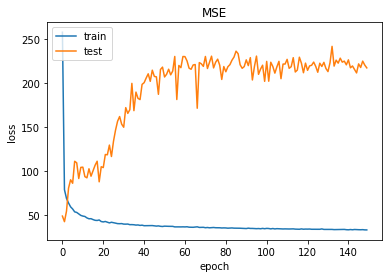

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

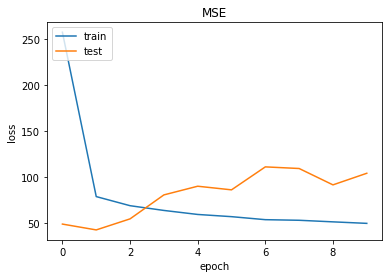

In [12]:
# summarize history for loss
plt.plot(history.history['loss'][:10])
plt.plot(history.history['val_loss'][:10])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

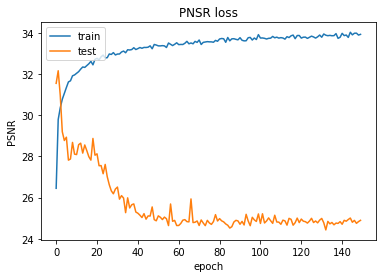

In [13]:
# summarize history for loss
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('PNSR loss')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
model.save_weights('conv2dlstm_1608_adam.h5')